### Importing the theoretical $D_{l}$ obtained with CAMB (Lewis et. al. 2006)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from input_camb import *
import healpy as hp

Using CAMB 1.5.7 installed at /home/akozameh/miniconda3/envs/CMB/lib/python3.10/site-packages/camb


In [46]:
# This Dl is used as input for synthetic map
Dl

array([   0.        ,    0.        , 1028.01454306, ...,   66.35034063,
         66.2225099 ,   66.09623955])

In [47]:
ls=np.arange((Dl.shape[0]))

In [48]:
ls

array([   0,    1,    2, ..., 2548, 2549, 2550])

In [49]:
lmax = 2000
nside=2048
mapa_cl = hp.sphtfunc.synfast(Dl, nside=nside, lmax =lmax, fwhm=np.radians(1/60), new= True)

[healpy] Sigma is 0.424661 arcmin (0.000124 rad) 
[healpy] -> fwhm is 1.000000 arcmin


[matplotlib.colorbar] locator: <healpy.projaxes.BoundaryLocator object at 0x7f0198323b80>


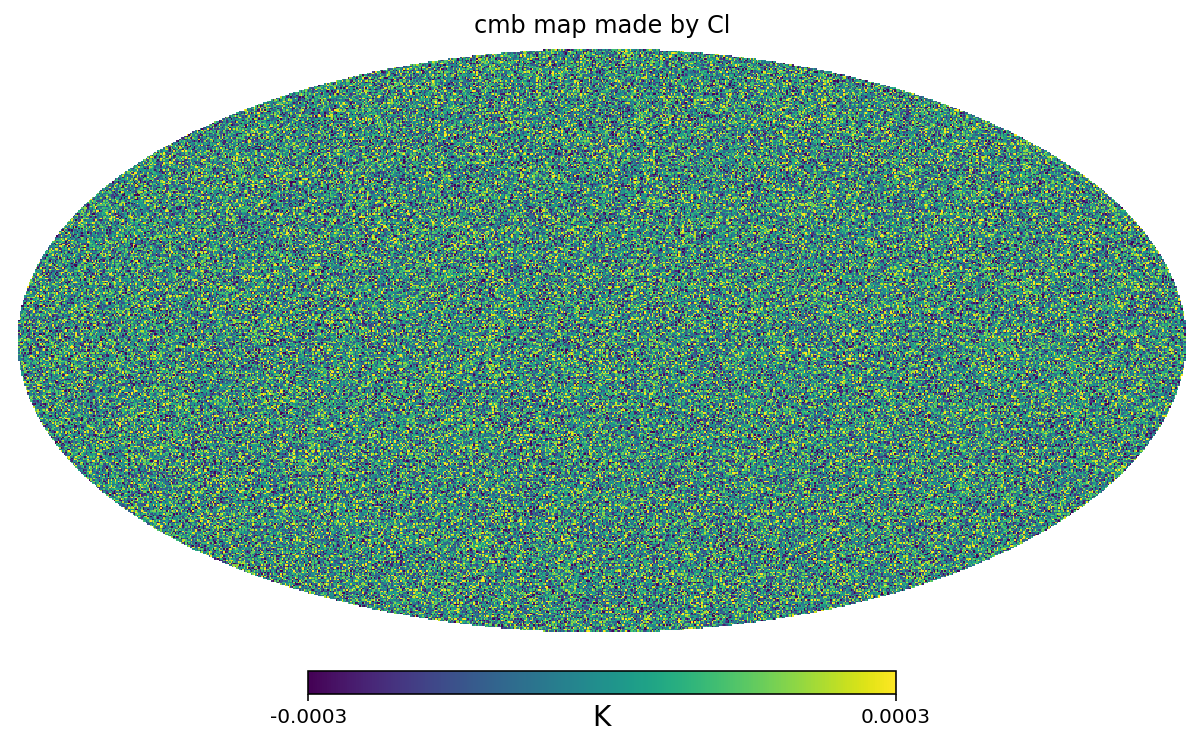

In [50]:
hp.mollview(mapa_cl*(1e-8), title = 'cmb map made by Cl', unit = 'K', min=-3e-4, max=3e-4)

In [51]:
#Saving the map
cmb_map=np.save('mapa_cl_1', mapa_cl)

In [39]:
# ells
Cls=hp.anafast(mapa_cl, lmax=2000)
el=np.arange(len(Cls))


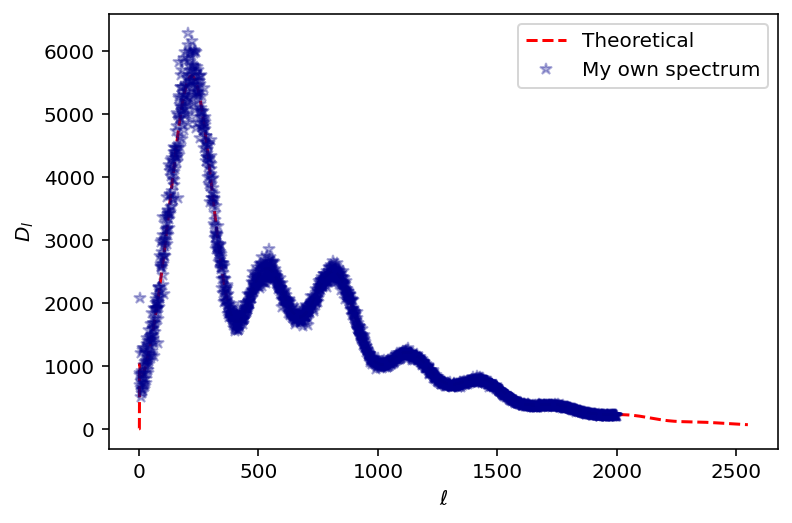

In [53]:
plt.plot(ls,Dl,'--',  color= 'r', label='Theoretical')
plt.plot(el[2:],Cls[2:], '*', alpha = 0.3, color = 'darkblue', label='My own spectrum')
plt.xlabel('$\ell$')
plt.ylabel(r'$D_l$')
plt.legend()

In [76]:
np.savetxt('Cl_s',Cls[2:])

Experimental errors

In [57]:
from IPython.display import display, Math
display(Math(r'\sigma(C_{\ell})= \sqrt{\frac{2}{(2l+1)f_{sky}}} \cdot C_{\ell}'))

<IPython.core.display.Math object>

In this subsection, I am going to compute the errors of pseudo \(C_\ell\). To compute the errors for thepower spectrum, you can estimate them using a simple approximation. One of the most straightforward methods is to assume that the errors are dominated by cosmic variance and noise, which gives:

$$\sigma(C_{\ell})= \sqrt{\frac{2}{(2l+1)f_{sky}} \cdot C_{\ell}}$$

Where $C_{\ell}$ are my pseudo power spectrum,
$f_{sky}=1$ is fraction of our sky for analysis.

In [77]:
Cl_err = np.sqrt(2 / (2*el[2:] + 1))*Cls[2:]
np.savetxt('sigma_1',Cl_err)

## MCMC with Cobaya (Lewis  & Torrado 2021)

In [60]:
from cobaya.likelihood import Likelihood
import os

In [85]:
# The CAMB's path
import camb
print(camb.__file__)


/home/akozameh/miniconda3/envs/CMB/lib/python3.10/site-packages/camb/__init__.py


I establish the Likelihood 

In [90]:
from cobaya.likelihood import Likelihood
import numpy as np

class MyLikelihood(Likelihood):
    
    def initialize(self):
        """
        Prepare any computation, importing necessary code, files, etc.
        Here, we load the Cls data.
        """
        # Load your data file, for example, experimental Cls
        self.data =   np.loadtxt(self.Cl_s) 
        
        # If you have associated errors, load them similarly (uncomment below if needed)
        
        self.error = np.loadtxt(self.sigma_1)
        
    def get_requirements(self):
        """
        Return dictionary specifying quantities calculated by a theory code.
        Here, we request C_l^{tt} (temperature) up to lmax = 2000.
        """
        return {'Cl': {'tt': 2000}}  # You can request other spectra like 'ee', 'te' if needed.
    
    def logp(self, **params_values):
        """
        Compute the log-likelihood given a set of parameter values.
        """
        # Get the theoretical Cls from the theory code (e.g., CAMB or CLASS)
        cls = self.provider.get_unlensed_Cl(ell_factor=True,units= 'FIRASmuK2')
       

        # Calculate chi-squared: sum of squared differences between data and theory Cls
        chi2 = np.sum(((self.data - cls['tt'][2:])/self.error) ** 2)  # Skipping ell=0,1 as usual

        # Return the log-likelihood (-0.5 * chi2)
        return -0.5 * chi2

    
        

Sampling the parameters

The base set of cosmological parameters we sample over are $\Omega_b h^{2}$ and $\Omega_c h^{2}$, the physical barion density and the CDM density
to critical density of universe, $h=H_0/(100 Km s^{-1} Mpc^{-1})$.

In [91]:
from cobaya import run

In [108]:
info_params = {
    "debug": True,  # Habilitar modo debug,
    "likelihood": {
        "MyLikelihood": MyLikelihood
    },
    # Theory block for CAMB
    "theory": {
        "camb": {
             "extra_args": {
                "lmax": 2000,  # Move lmax here
                "stop_at_error": True
            }
        }
    },
    
    # Parameters
    "params": {
        "ombh2": {
            "prior": {"min": 0.005, "max": 0.1}, 
            "ref": {
                "dist": "norm",
                "loc": 0.0221,
                "scale": 0.0001
            },
            "proposal": 0.0001,
            "latex": r"\Omega_b h^{2}"
        },
        "omch2": {
            "prior": {"min": 0.05, "max": 0.5}, 
            "ref": {
                "dist": "norm",
                "loc": 0.121,
                "scale": 0.001
            },
            "proposal": 0.0005,
            "latex": r"\Omega_c h^{2}"
        }
    },
    
    # Sampler
    "sampler": {
        "mcmc": {
            "max_samples": 1000
        }
    },
    
    # Output and resuming settings
    "resume": False  # Disable resuming
}



In [109]:
updated_info, sampler =run(info_params)

[outputdummy] No output requested. Doing nothing.
[run] Input info updated with defaults (dumped to YAML):
theory:
  camb:
    version: null
    path: null
    speed: 0.3
    stop_at_error: false
    extra_args:
      lmax: 2000
      stop_at_error: true
    ignore_obsolete: false
    use_renames: false
    external_primordial_pk: false
    renames:
      omegabh2: ombh2
      omegach2: omch2
      omegal: omega_de
      omegak: omk
      yhe: YHe
      yheused: YHe
      YpBBN: Y_p
likelihood:
  MyLikelihood:
    type: []
    speed: -1
    stop_at_error: false
    version: null
    external: !!python/name:__main__.MyLikelihood ''
params:
  ombh2:
    prior:
      min: 0.005
      max: 0.1
    ref:
      dist: norm
      loc: 0.0221
      scale: 0.0001
    proposal: 0.0001
    latex: \Omega_b h^{2}
    renames:
    - omegabh2
  omch2:
    prior:
      min: 0.05
      max: 0.5
    ref:
      dist: norm
      loc: 0.121
      scale: 0.001
    proposal: 0.0005
    latex: \Omega_c h^{2}
  

AttributeError: 'MyLikelihood' object has no attribute 'Cl_s'